## Scaling factor

---

In [1]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.spec import Spec
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.helpers.variables import Variables

#### 1. Define obstacle

In [2]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
circle_dict = {
    'type': 'SphereObstacle',
    'geometry': {
        'position': [1.0, 0.0],
        'radius': 0.5,
    }
}
obstacle = SphereObstacle(name="CircleObstacle", content_dict = circle_dict)

#### 2. Define action and configuration space

In [3]:
x_o = ca.SX.sym('x_o', 1)
xdot_o = ca.SX.sym('xdot_o', 1)

x = ca.SX.sym('x', 2)
xdot = ca.SX.sym('xdot', 2)
variables = Variables(state_variables={'x': x, 'xdot': xdot})

#### 3. Create baseline spec in configuration space

In [4]:
#h_b = ca.vcat([x[0]*0, x[1]*0])
#lambda_b = 1

#Le_b = lambda_b / 2 * ca.mtimes(ca.transpose(x), x)
#Me_b = ca.jacobian(ca.jacobian(Le_b, xdot), xdot)

#spec_b = Spec(Me_b, h=h_b, x=x, xdot=xdot)
#spec_b.concretize()

#### 4. Create collision spec in state space, pulled back to configuration space

In [5]:
phi_o = (ca.norm_2(x - obstacle.position()) / obstacle.radius() - 1)**2
psi_o = 1 / (phi_o)
der_psi_o = ca.jacobian(psi_o, x_o)
h_o = xdot_o**2 * der_psi_o

Le_o = 0.5 * (ca.heaviside(-xdot_o)) * (1/x_o) * xdot_o**2
Me_o = ca.jacobian(ca.jacobian(Le_o, xdot_o), xdot_o)

spec_o = Spec(Me_o, h=h_o, x=x_o, xdot=xdot_o)

diff_map_o = DifferentialMap(phi_o, variables)
pulled_spec_o = spec_o.pull(diff_map_o)
pulled_spec_o.concretize()

#### 4. Sum together all specs, with `n_obs` number of obstacle specs

In [6]:
def collision_spec_summator(n_obs=1):
    #he = spec_b.h() + n_obs * pulled_spec_o.h()
    #Le = Le_b + n_obs * Le_o
    he = n_obs * pulled_spec_o.h()
    Le = n_obs * Le_o
    Me = ca.jacobian(ca.jacobian(Le, xdot), xdot)

    spec = Spec(Me, h=he, x=x, xdot=xdot)
    spec.concretize()
    return spec

n_obs = 5
specs = {}
all_positions = {}
for n_ob in range(n_obs):
    specs[f"spec{n_ob}"] = collision_spec_summator(n_ob + 1)
    all_positions[f"spec{n_ob}"] = 0

### Planar simulation of simple collision avoidance spec

Test the spec inside a planar simulation environment.\
The spec produces a trajectory which will be visualized by the environment.

In [7]:
import gym
import numpy as np
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### 1. Run the simulation to create the trajectory

In [8]:
def spec_simulator(spec):
    env = gym.make("point-robot-acc-v0", render=False, dt=0.01)
    init_pos = np.array([-1.0, 0.1])
    init_vel = np.array([1.3, 0.0])
    ob = env.reset(pos=init_pos, vel=init_vel)
    env.add_obstacle(obstacle)
    n_steps = 1000
    positions = np.zeros((n_steps, 2))
    for i in range(n_steps):
        x = ob['joint_state']['position']
        positions[i] = x
        xdot = ob['joint_state']['velocity']
        M, h, action = spec.evaluate(x=x, xdot=xdot)
        ob, _, _, _ = env.step(action)
    env.close()
    return positions

for spec in specs:
    all_positions[f'{spec}'] = spec_simulator(specs[f'{spec}'])
    
positions = all_positions['spec0']

#### 2. Visualize the trajectory

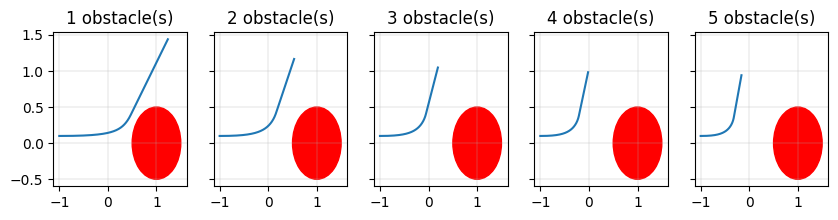

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, n_obs, sharex=True, sharey=True, figsize = (n_obs*2, 1*2))
n = 0
for spec in specs:
    axs[n].plot(all_positions[f'{spec}'][:,0], all_positions[f'{spec}'][:,1])
    obst = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
    axs[n].add_patch(obst)
    axs[n].grid(linestyle='-', linewidth=0.3, alpha=0.8)
    axs[n].title.set_text(f'{n + 1} obstacle(s)')
    n += 1
plt.show()